# This notebook take the input from omega_analysis.ipynb output omega*.npy, and using DeepTime package to cluster them.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace
from deeptime.clustering import BoxDiscretization

import mdtraj as md
import re, math, os, shutil

import warnings; warnings.simplefilter('ignore')

### Import the data 

In [2]:
# import omega data
omegas = np.load('omega_data/omegas_state0.npy')
print(omegas)
print(f"omegas.shape: {omegas.shape}")
print(f"omegas.dtype: {omegas.dtype}")

[[ 176.61365    -155.1119     -164.74222     179.77354    -129.95387
   150.1715    ]
 [-172.74445    -138.93884    -152.50238     168.66266    -113.28047
   167.78793   ]
 [ 166.22908    -169.03804    -120.83381    -170.46118    -123.77456
   158.05635   ]
 ...
 [   7.6682663  -171.25986     -13.6714     -163.44185     -30.11108
   176.28467   ]
 [  19.445396   -154.76286      10.1307335  -153.82687      -7.872507
   167.99112   ]
 [   0.19429666  178.75386     -20.960945    167.70544      20.362501
   178.45613   ]]
omegas.shape: (30001, 6)
omegas.dtype: float32


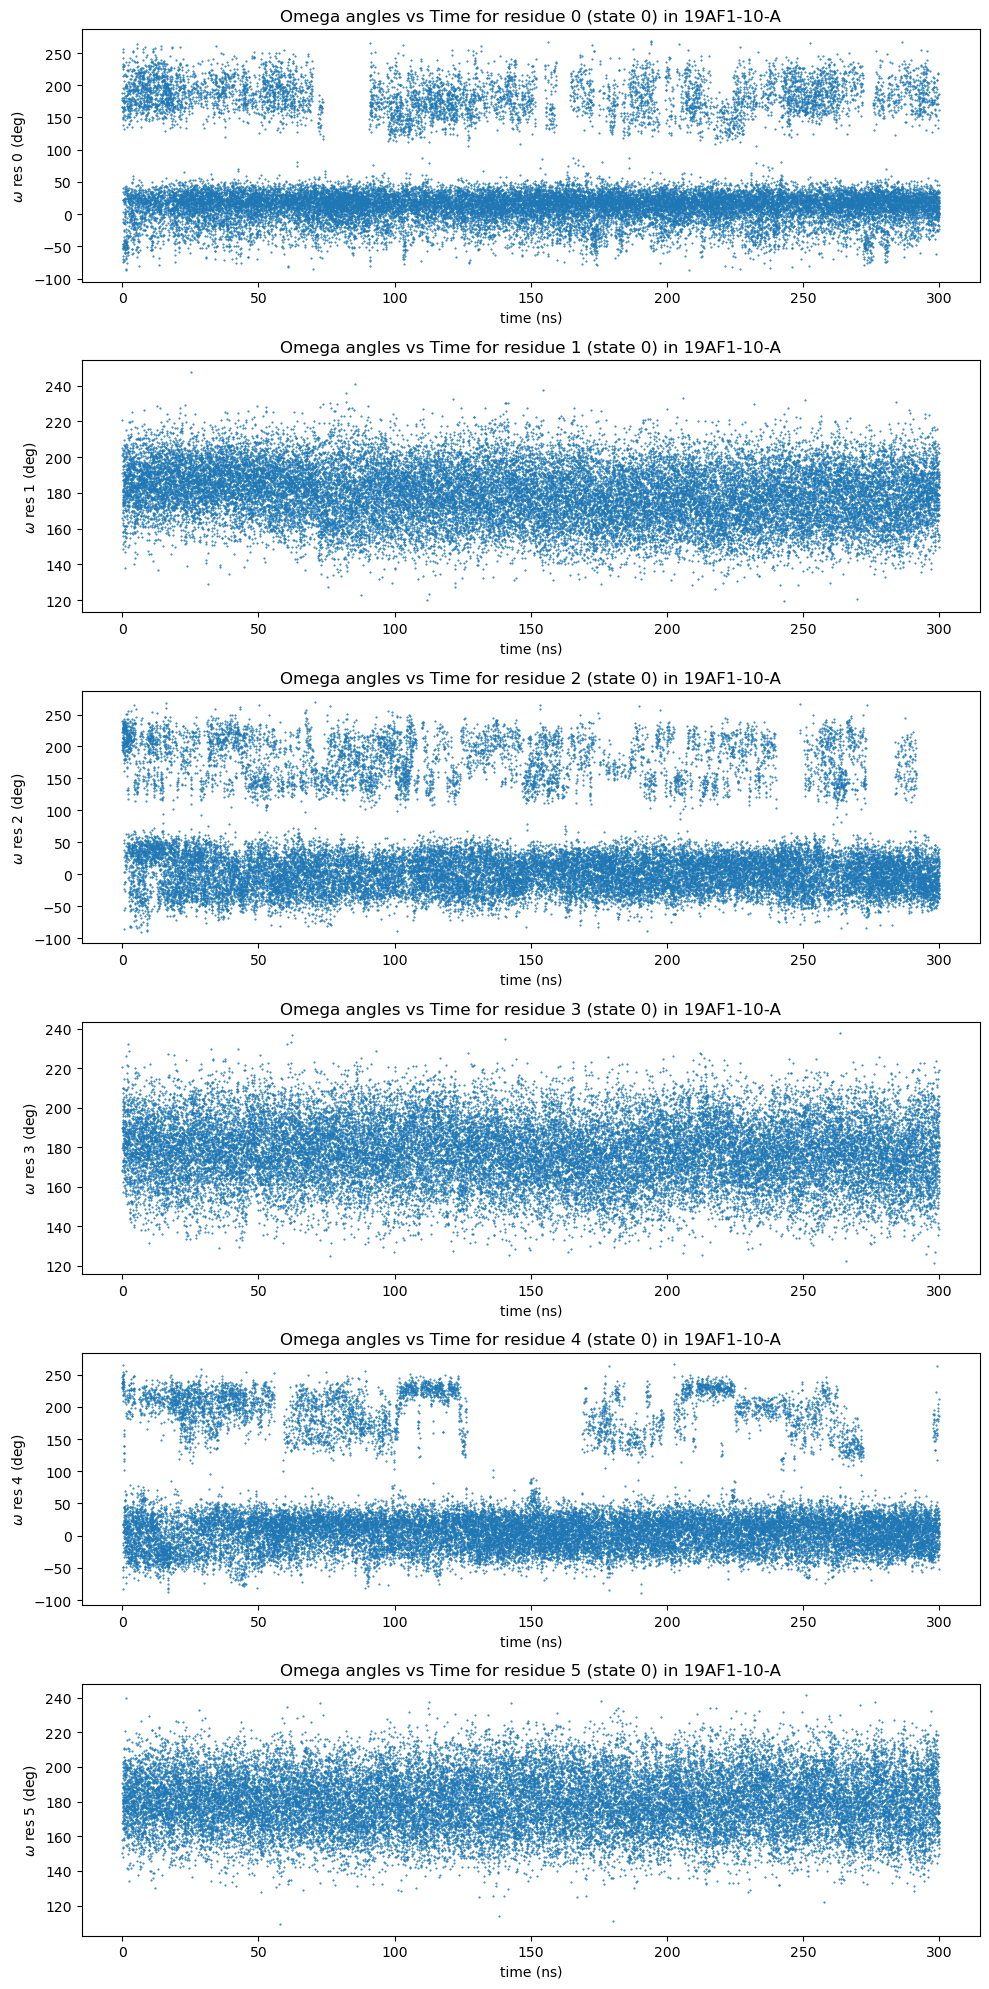

In [5]:
# Plotting the omegas 
omegas = (omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)

start = 0
nsnaps = 30001
t = np.arange(start, nsnaps) * 0.01 # Tims axis in ns 
residues_to_plot = [0, 1, 2, 3, 4, 5]
num_residues = len(residues_to_plot)

plt.figure(figsize=(10, 20))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omegas[start:nsnaps, residue], '.', ms=1)
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ res {residue} (deg)')
    plt.title(f'Omega angles vs Time for residue {residue} (state 0) in 19AF1-10-A')
plt.tight_layout()
plt.show()

### Clustering Method

In [6]:
regularspace_estimator = RegularSpace(
    dmin=170,        # minimum distance between cluster centers, 180 degree
    max_centers=64,   # maximum number of cluster centers
    n_jobs=8
)

kmean_estimator = KMeans(
    n_clusters=128,              # place 100 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=100000000,        # don't actually perform the optimization, just place centers
    fixed_seed=42,             # Treat this as hyperparameter 
    n_jobs=8,
    progress=tqdm
)

In [7]:
# Fit the omegas data into model 
clustering = regularspace_estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

print(clustering.cluster_centers)

[[176.61365   204.88812   195.25778   179.77356   230.04614   150.1715   ]
 [251.21957   195.07898   227.422     170.48657   -48.684532  178.76837  ]
 [-49.235134  173.21225   225.10004   181.45367    17.234169  147.74744  ]
 [-69.56307   169.03458   213.55725   188.27151   248.80804   164.06404  ]
 [-51.437065  183.97955   -84.968895  173.11865   -23.758644  169.37408  ]
 [222.12128   149.69125    38.744476  203.19614    -1.4797211 189.11377  ]
 [ 23.065125  188.92395    -5.3915176 197.67554   211.21521   184.3855   ]
 [ 54.7621    197.78918    35.68184   189.76172    44.80638   160.7841   ]
 [224.07693   167.7684     35.95025   169.58575   212.17966   200.7876   ]]


### The population of each cluster:

In [18]:
# count the number of each cluter 
counts = Counter(assignments)
#print(counts)

# Sort the counts 
sorted_counts = dict(sorted(counts.items()))
total_counts = sum(counts.values())
cluster = []

for label, frequency in sorted_counts.items():    
    precentage = (frequency / total_counts) * 100 
    cluster.append(precentage)
    print(f"Assignment {label}: {frequency}, {precentage:.4g}%")

outfile = 'sampling/clusters_probability.dat'
np.savetxt(outfile, cluster)

Assignment 0: 467, 1.557%
Assignment 1: 1401, 4.67%
Assignment 2: 2926, 9.753%
Assignment 3: 569, 1.897%
Assignment 4: 3897, 12.99%
Assignment 5: 3321, 11.07%
Assignment 6: 2774, 9.246%
Assignment 7: 13476, 44.92%
Assignment 8: 1170, 3.9%


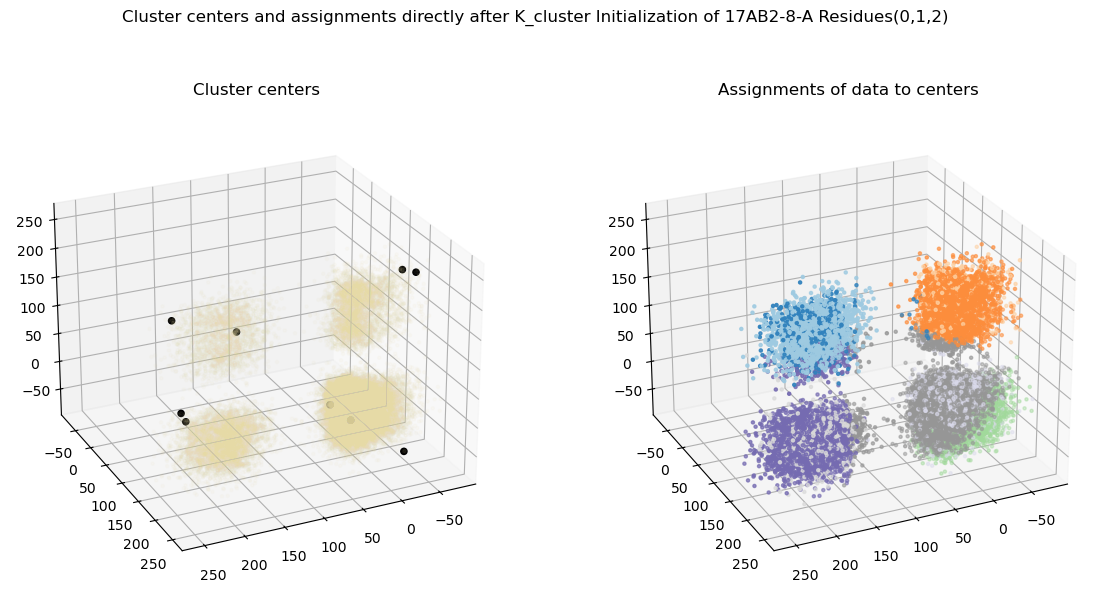

In [10]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 17AB2-8-A Residues(0,1,2)')
fig.savefig('omega_data/cluster_centers_and_assignments_residues(0,1,2).png', dpi=300, bbox_inches='tight')
plt.show()

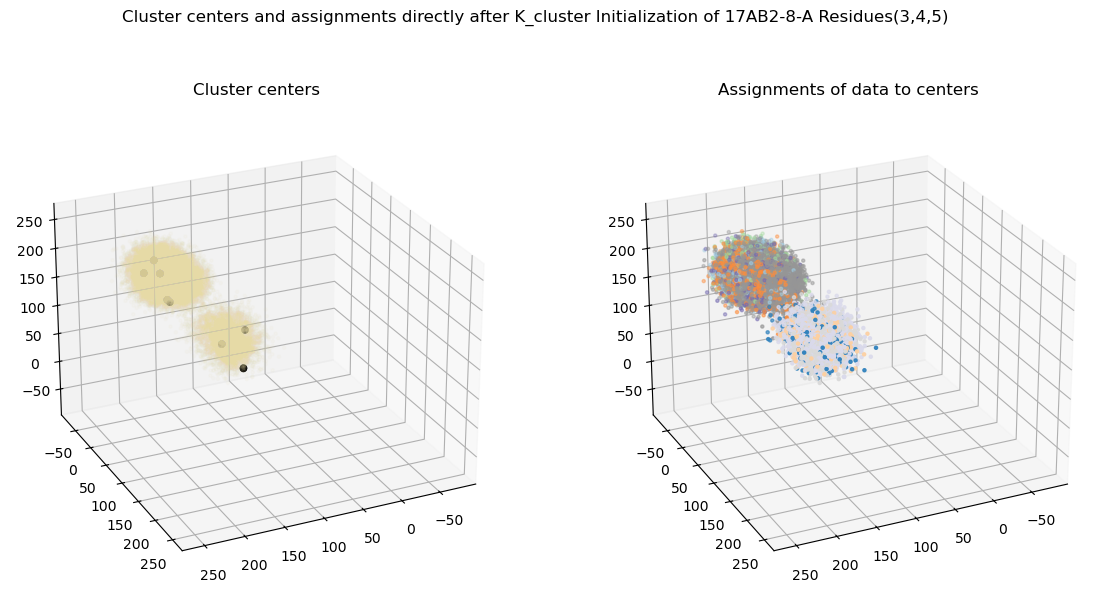

In [11]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 3], clustering.cluster_centers[:, 4], clustering.cluster_centers[:, 5], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 17AB2-8-A Residues(3,4,5)')
fig.savefig('omega_data/cluster_centers_and_assignments_residues(3,4,5).png', dpi=300, bbox_inches='tight')
plt.show()

### Calculate the Inertias:

$$
\sum_{i=1}^{k} \sum_{x_j \in S_i} \|\mathbf{x}_j - \mu_i\|^2
$$


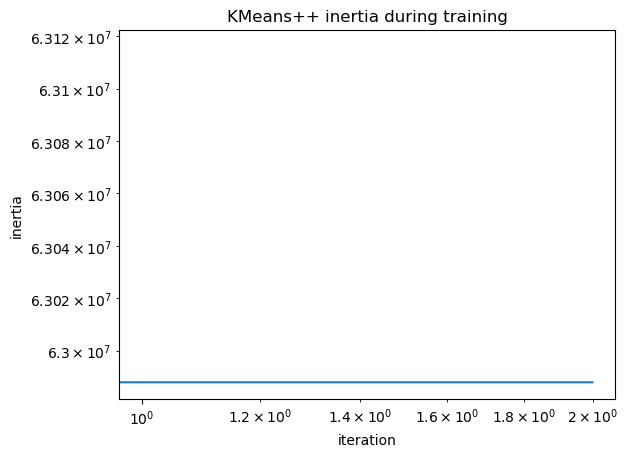

In [29]:
plt.loglog(clustering.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans++ inertia during training");

### Plot the Solution NMR Crystal Structure 

In [12]:
# Define dihedral indices
gmx_dihedral_indices = [
    [58, 59, 60, 61],
    [61, 62, 63, 64],
    [64, 65, 66, 1],
    [1, 2, 3, 4],
    [4, 5, 6, 7],
    [7, 8, 9, 10]
]

# Convert indices to zero-based for numpy
nmr_dihedral_indices = np.array(gmx_dihedral_indices) - 1
#print(nmr_dihedral_indices.shape)

# Load NMR structure
pdb = '../../../nmr_structure/ja7b02319_si_003.pdb'
traj = md.load(pdb)
nmr_omegas = []

# Extract the omegas angle through MDtraj
traj = md.load(pdb)
nmr_omegas = md.compute_dihedrals(traj, nmr_dihedral_indices) * (180.0 / math.pi) 
print(nmr_omegas, nmr_omegas.shape)

# Save omegas
omega_path = 'omega_data/'
outfile = os.path.join(omega_path, f"NMR_omegas.npy")
np.save(outfile, nmr_omegas)
print(f"Saved NMR omegas to {outfile}") 

[[  16.494799  167.66855   -34.175865 -153.96979    29.759544  164.99388 ]
 [ -15.495207  171.48349   -32.16132  -154.35583    30.603268  163.81451 ]
 [  20.377672  175.2889    -34.512657 -164.97351    28.566313  163.60995 ]
 [  16.418581  167.64268   -34.203888 -154.00578    29.729813  164.96019 ]
 [  16.418581  167.64268   -34.203888 -154.00578    29.729813  164.96019 ]
 [  19.4981    160.57515   -25.122976 -151.5662     25.574886 -171.06056 ]
 [  22.83097   178.9422    -27.254711 -153.75142    33.541008 -156.72847 ]
 [  25.971334  167.744     -31.67458  -151.01103    30.676617  172.05762 ]
 [  23.877535  151.7077    -31.803427 -155.23964    31.733414  179.3501  ]
 [  26.074434  160.75085   -32.970455 -158.84132    31.226707 -179.80226 ]
 [  24.181446  156.72253   -33.223682 -160.51964    31.852823 -176.8941  ]
 [  18.809547  167.56654   -34.568542 -152.60738    30.405615  165.4699  ]] (12, 6)
Saved NMR omegas to omega_data/NMR_omegas.npy


In [50]:
#### CHECK CODE ####

# Define dihedral indices
gmx_dihedral_indices = [
    [2, 4, 27, 28],
    [28, 30, 60, 61],
    [61, 63, 86, 87],
    [87, 89, 127, 128],
    [128, 130, 152, 153],
    [153, 155, 186, 187],
    [187, 189, 206, 207],
    [207, 209, 231, 232],
    [232, 234, 252, 253],
]

# Convert indices to zero-based for numpy
nmr_dihedral_indices = np.array(gmx_dihedral_indices) - 1

# Load NMR structure
pdb = '../../../nmr_structure/ja9b10497_si_005.pdb'
traj = md.load(pdb)
topology = traj.topology

# Function to get atom names from indices
def get_atom_names(indices):
    atom_names = []
    for index in indices:
        atom_names.append(topology.atom(index).name)
    return atom_names

# Compute dihedrals for each segment and print atom names
for i in range(10):
    indices_offset = nmr_dihedral_indices + 288 * i
    print(f"Indices offset for segment {i+1}:")
    print(indices_offset)
    for indices in indices_offset:
        atom_names = get_atom_names(indices)
        print(f"Atom names for indices {indices}: {atom_names}")
    
    nmr_omegas_single = md.compute_dihedrals(traj, indices_offset) * (180.0 / math.pi)
    print(f"Dihedrals for segment {i+1}:")
    print(nmr_omegas_single)
    print()

Indices offset for segment 1:
[[  1   3  26  27]
 [ 27  29  59  60]
 [ 60  62  85  86]
 [ 86  88 126 127]
 [127 129 151 152]
 [152 154 185 186]
 [186 188 205 206]
 [206 208 230 231]
 [231 233 251 252]]
Atom names for indices [ 1  3 26 27]: ['CA', 'C', 'N', 'CA']
Atom names for indices [27 29 59 60]: ['CA', 'C', 'N', 'CA']
Atom names for indices [60 62 85 86]: ['CA', 'C', 'N', 'CA']
Atom names for indices [ 86  88 126 127]: ['CA', 'C', 'N', 'CA']
Atom names for indices [127 129 151 152]: ['CA', 'C', 'N', 'CA']
Atom names for indices [152 154 185 186]: ['CA', 'C', 'N', 'CA']
Atom names for indices [186 188 205 206]: ['CA', 'C', 'N', 'CA']
Atom names for indices [206 208 230 231]: ['CA', 'C', 'N', 'CA']
Atom names for indices [231 233 251 252]: ['CA', 'C', 'N', 'CA']
Dihedrals for segment 1:
[[ -23.294558   174.72609      8.518006  -163.80301     14.704825
  -179.82207      5.8536844 -165.11176    -13.641238 ]]

Indices offset for segment 2:
[[289 291 314 315]
 [315 317 347 348]
 [348 350

In [13]:
nmr_omegas = np.load('omega_data/NMR_omegas.npy')
print(f"nmr_omegas.shape: {nmr_omegas.shape}")
print(f"nmr_omegas.dtype: {nmr_omegas.dtype}")

nmr_omegas = (nmr_omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)
print(nmr_omegas)

nmr_omegas.shape: (12, 6)
nmr_omegas.dtype: float32
[[ 16.494797 167.66855  -34.175865 206.03021   29.759544 164.99388 ]
 [-15.495209 171.48349  -32.16132  205.64417   30.603271 163.81451 ]
 [ 20.37767  175.28888  -34.512657 195.02649   28.566315 163.60995 ]
 [ 16.41858  167.6427   -34.203888 205.9942    29.729813 164.96019 ]
 [ 16.41858  167.6427   -34.203888 205.9942    29.729813 164.96019 ]
 [ 19.4981   160.57515  -25.122978 208.4338    25.57489  188.93945 ]
 [ 22.83097  178.9422   -27.254711 206.2486    33.541008 203.27155 ]
 [ 25.971336 167.74402  -31.67458  208.98895   30.67662  172.05762 ]
 [ 23.877533 151.7077   -31.803429 204.76038   31.733414 179.3501  ]
 [ 26.074432 160.75085  -32.970455 201.15869   31.226707 180.19775 ]
 [ 24.181442 156.72253  -33.223682 199.48035   31.852821 183.1059  ]
 [ 18.809547 167.56653  -34.568542 207.39264   30.405617 165.4699  ]]


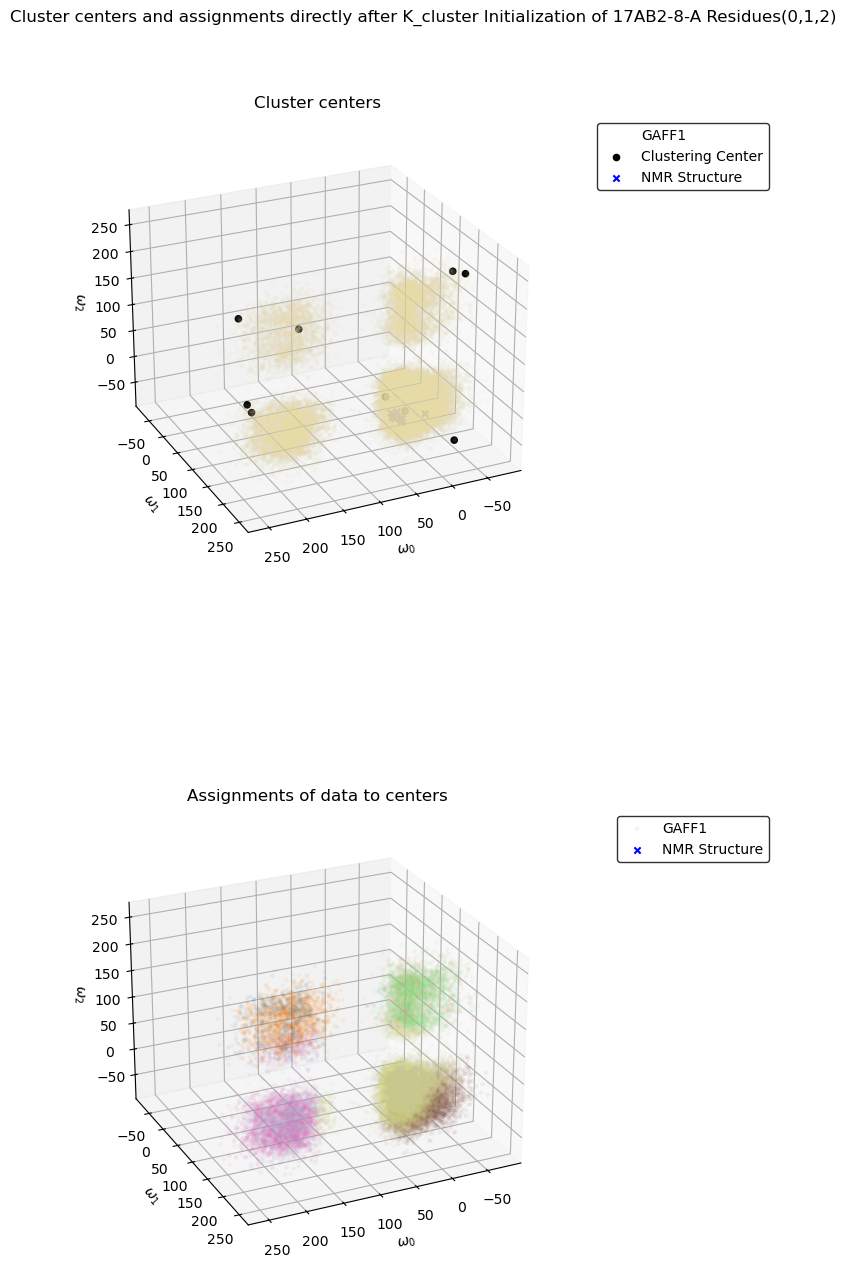

In [15]:
fig = plt.figure(figsize=(7, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05, label='GAFF1')
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.scatter(nmr_omegas[:, 0], nmr_omegas[:, 1], nmr_omegas[:, 2], marker = 'x', c='b', label='NMR Structure')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Label each cluster center
#for i, (x, y, z) in enumerate(clustering.cluster_centers):
#    ax1.text(x, y, z, f'Cluster {i}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', alpha=0.05 , cmap='tab20', label='GAFF1')
ax2.scatter(nmr_omegas[:, 0], nmr_omegas[:, 1], nmr_omegas[:, 2], marker = 'x', alpha=1, c='b', label='NMR Structure')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_0$')
ax1.set_ylabel(r'$\omega_1$')
ax1.set_zlabel(r'$\omega_2$')

ax2.set_xlabel(r'$\omega_0$')
ax2.set_ylabel(r'$\omega_1$')
ax2.set_zlabel(r'$\omega_2$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 17AB2-8-A Residues(0,1,2)')
fig.savefig('omega_data/cluster_centers_and_assignments_residue(0,1,2).png', dpi=300, bbox_inches='tight')
plt.show()

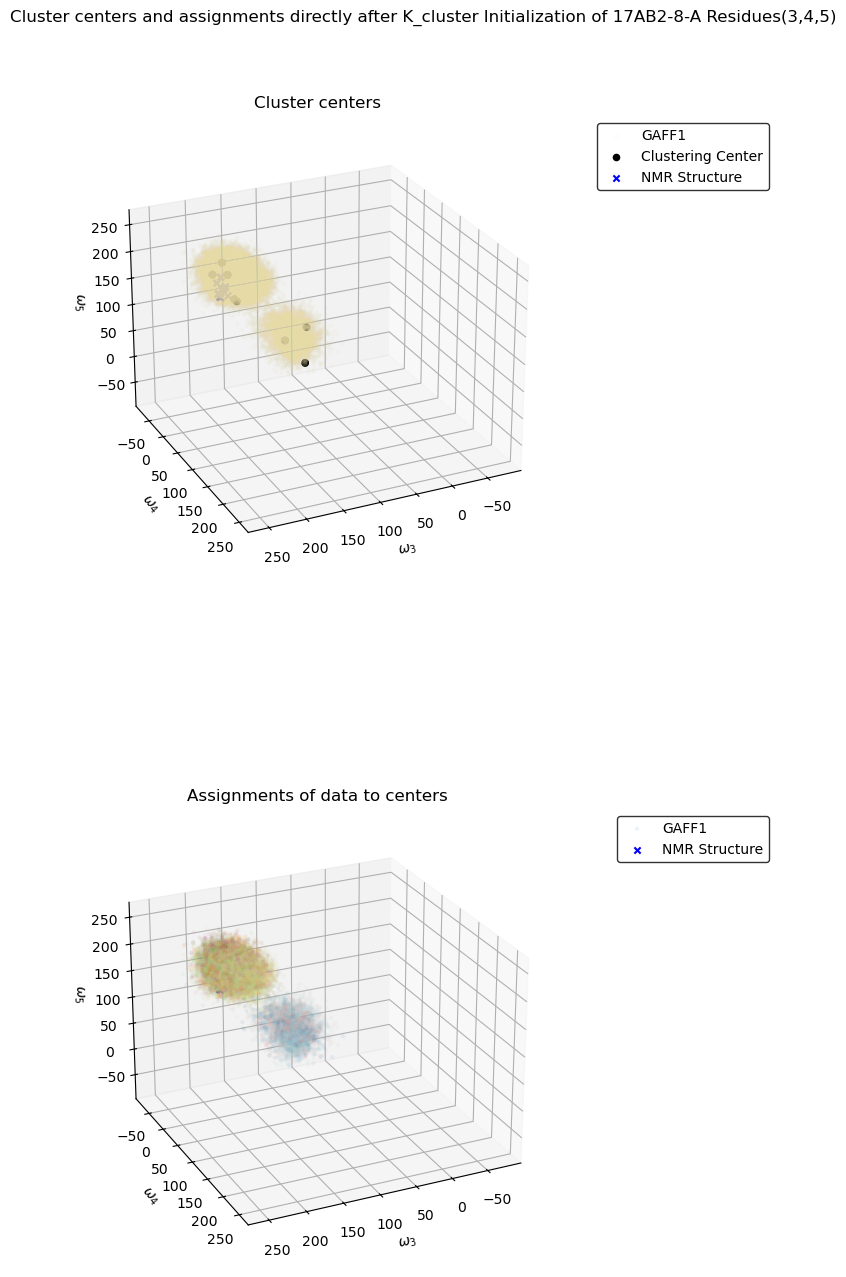

In [16]:
fig = plt.figure(figsize=(7, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c='#E6DAA6', marker='.', alpha=0.05, label='GAFF1')
ax1.scatter(clustering.cluster_centers[:, 3], clustering.cluster_centers[:, 4], clustering.cluster_centers[:, 5], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.scatter(nmr_omegas[:, 3], nmr_omegas[:, 4], nmr_omegas[:, 5], marker = 'x', c='b', label='NMR Structure')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Label each cluster center
#for i, (x, y, z) in enumerate(clustering.cluster_centers):
#    ax1.text(x, y, z, f'Cluster {i}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c=assignments[:], marker='.', alpha=0.05 , cmap='tab20', label='GAFF1')
ax2.scatter(nmr_omegas[:, 3], nmr_omegas[:, 4], nmr_omegas[:, 5], marker = 'x', alpha=1, c='b', label='NMR Structure')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_3$')
ax1.set_ylabel(r'$\omega_4$')
ax1.set_zlabel(r'$\omega_5$')

ax2.set_xlabel(r'$\omega_3$')
ax2.set_ylabel(r'$\omega_4$')
ax2.set_zlabel(r'$\omega_5$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 17AB2-8-A Residues(3,4,5)')
fig.savefig('omega_data/cluster_centers_and_assignments_residue(3,4,5).png', dpi=300, bbox_inches='tight')
plt.show()

### Sampling from Clusters

In [17]:
# Define the directory path
directory = "sampling/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")

Directory 'sampling/' did not exist, so it has been created.


In [19]:
import numpy as np
import mdtraj as md

# Create Cluster Dictionary
clusters = {assignment: [] for assignment in np.unique(assignments)}
#print(cluster)

# Store the frame index in each cluster
for index, assignment in enumerate(assignments):
    clusters[assignment].append(index)

#print(cluster)
print(type(clusters))
print(clusters[1])

# Create Frame Dictionary for containing the sampling frame 
frames = {assignment: [] for assignment in np.unique(assignments)}
#print(frames)
print(len(frames))

# Randomly sample 10 frames from each cluster
for i in range(len(frames)):
    if len(clusters[i]) > 10:
        indices = np.random.choice(clusters[i], size=10, replace=True)
        frames[i] = indices.tolist()
    else:
        print(f"Cluster {i} skipped. Only {len(clusters[i])} frames available.")


# Load trajectory
xtcfile = "state_0/HREMD.part0001_whole.xtc"
grofile = "state_0/HREMD.part0001_withoutsolvent.gro"
traj = md.load(xtcfile, top=grofile)

# Save sampled frames to new xtc files
for cluster in frames:
    sampling = traj[frames[cluster]]    
    sampling.save_xtc(f"sampling/sample_state_0_cluster{cluster}.xtc")
    sampling.save_pdb(f"sampling/sample_state_0_cluster{cluster}.pdb")

<class 'dict'>
[8, 9, 15, 72, 73, 86, 87, 90, 91, 96, 97, 104, 105, 116, 117, 118, 119, 131, 136, 137, 138, 139, 148, 149, 152, 153, 156, 157, 160, 161, 168, 169, 172, 173, 178, 179, 184, 185, 196, 197, 204, 205, 218, 219, 220, 221, 222, 223, 224, 225, 234, 235, 238, 239, 252, 253, 260, 261, 272, 273, 284, 285, 290, 291, 292, 293, 298, 299, 310, 311, 312, 322, 323, 334, 335, 346, 347, 352, 353, 358, 359, 382, 383, 388, 389, 400, 401, 412, 413, 416, 417, 422, 423, 426, 427, 443, 444, 445, 456, 457, 472, 473, 488, 489, 502, 503, 506, 510, 511, 520, 521, 525, 536, 537, 548, 553, 558, 571, 580, 581, 588, 589, 612, 613, 622, 623, 634, 635, 646, 647, 656, 657, 668, 669, 680, 681, 692, 693, 702, 703, 714, 715, 738, 739, 746, 747, 748, 749, 762, 763, 774, 775, 780, 781, 792, 793, 804, 805, 816, 817, 834, 835, 851, 852, 853, 864, 865, 890, 891, 892, 904, 916, 917, 928, 929, 936, 937, 954, 955, 958, 959, 962, 963, 970, 971, 984, 985, 988, 989, 1000, 1001, 1012, 1013, 1018, 1019, 1038, 1039, 1046

In [20]:
%%bash

# copy a fake.tpr from other directory 
cp state_0/fake.tpr sampling/
cp state_0/HREMD.part0001_withoutsolvent.gro sampling/

cd 'sampling'

for cluster in {0..8}
do
    # Run the gmx trjconv command with the current cluster number and provide the necessary input
    echo "0" | gmx trjconv -f "sample_state_0_cluster${cluster}.xtc" -s "fake.tpr" -pbc whole -o "sample_state_0_cluster${cluster}_whole.xtc"
done

# Remove GROMACS backup files
rm \#*

cd ..

# Print the current working directory
pwd


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
/Users/starwingchen/Voelz_Lab/git/peptoid_24summer/peptoid/17AB2-8-A/GAFF/neutral/HREX_300ns


In [21]:
# Save the whole xtc back into pdb using MDtraj

ncluster = 9

for cluster in range(ncluster):
    xtcfile = f"sampling/sample_state_0_cluster{cluster}_whole.xtc"
    grofile = 'sampling/HREMD.part0001_withoutsolvent.gro'
    try:
        traj = md.load(xtcfile, top=grofile)
        output_pdbfile = f"sampling/sample_state_0_cluster{cluster}_whole.pdb"
        traj.save_pdb(output_pdbfile)

    except Exception as e:
        print(f"Cluster {cluster} skipped. Error: {e}")